In [1]:
#imports
import os
import glob as gb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
import tempfile

#tensorflow imports
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#copy dataset from drive
!cp -r ./drive/MyDrive/fer.zip ./

#import
import zipfile

with zipfile.ZipFile("./fer.zip", "r") as zip_ref:
    zip_ref.extractall("./")

#copy validation 
!cp -r "./test" "./validation" 

#paths to sets
train_dir = "./train"
test_dir = "./test"
val_dir = "./validation"

#remove Public images from testing dir
for root, subdirs, files in os.walk(test_dir):
    for file in files:
        if file.startswith("Public"):
            os.remove(os.path.join(root,file))



#remove Private images from validation dir
for root, subdirs, files in os.walk(val_dir):
    for file in files:
        if file.startswith("Private"):
            os.remove(os.path.join(root,file))

#set batch size and classes
batch = 64
classes = ["angry", "fear", "happy","neutral","sad","surprise"]

In [4]:
#set training data without data augmentation
train_datagen = ImageDataGenerator(rescale = 1./255)

#normalize validation data
val_datagen = ImageDataGenerator(rescale = 1./255)

#normalize test data
test_datagen = ImageDataGenerator(rescale = 1./255)



#get training set
training_set = train_datagen.flow_from_directory(train_dir,\
                                                 target_size = (48, 48),\
                                                 color_mode = "grayscale",\
                                                 class_mode = "categorical",\
                                                 shuffle = True,\
                                                 batch_size=batch,\
                                                 classes=classes)

#get val set
val_set = val_datagen.flow_from_directory(val_dir, target_size = (48, 48),\
                                            color_mode = "grayscale",\
                                            class_mode = "categorical",\
                                            classes = classes,\
                                            batch_size=batch,\
                                            shuffle = False)

#get test set
test_set = test_datagen.flow_from_directory(test_dir, target_size = (48, 48),\
                                            color_mode = "grayscale",\
                                            class_mode = "categorical",\
                                            classes = classes,\
                                            batch_size=batch,\
                                            shuffle = False)
print(training_set.class_indices)
print("angry", training_set.classes[training_set.classes == 0].shape[0])
print("fear", training_set.classes[training_set.classes == 1].shape[0])
print("happy", training_set.classes[training_set.classes == 2].shape[0])
print("neutral", training_set.classes[training_set.classes == 3].shape[0])
print("sad", training_set.classes[training_set.classes == 4].shape[0])
print("surprise", training_set.classes[training_set.classes == 5].shape[0])

Found 28273 images belonging to 6 classes.
Found 3533 images belonging to 6 classes.
Found 3534 images belonging to 6 classes.
{'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}
angry 3995
fear 4097
happy 7215
neutral 4965
sad 4830
surprise 3171


In [11]:
#model1
def model1(training_set):
    #init cnn
    model = Sequential()

    #Conv1
    model.add(Conv2D(64, kernel_size=(3, 3), padding="same", input_shape = (48, 48, 1)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    #Conv2
    model.add(Conv2D(128, kernel_size=(3, 3), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    #Conv3
    model.add(Conv2D(256, kernel_size=(3, 3), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    #Conv4
    model.add(Conv2D(512, kernel_size=(3, 3), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    #Flatten
    model.add(Flatten())

    #Dense
    model.add(Dense(units = 512, activation = "relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(units = 512, activation = "relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(units = 6, activation = "softmax"))

    opt = Adam(learning_rate=0.01) #norm 0.001
    #Compiling CNN
    model.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ["accuracy"])

    return model

In [12]:
#init models
model1 = model1(training_set)
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_18 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 128)      

In [13]:
#save_paths
save_path1 = "./drive/MyDrive/model1.h5"
checkpoint1 = ModelCheckpoint(save_path1, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")

#RLP
reduce_learning_rate = ReduceLROnPlateau(monitor="val_loss", factor=0.9, patience=5, min_lr=0.0001)

#Early stopping
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10)

#Epochs
epochs = 100

#fit model1
history1 = model1.fit(training_set,epochs = epochs,\
                      validation_data = val_set,\
                      callbacks=[checkpoint1, reduce_learning_rate, early_stopping])

Epoch 1/100
441/442 [============================>.] - ETA: 0s - loss: 1.9490 - accuracy: 0.2600
Epoch 1: val_accuracy improved from -inf to 0.21540, saving model to ./drive/MyDrive/model1.h5
442/442 [==============================] - 37s 46ms/step - loss: 1.9480 - accuracy: 0.2603 - val_loss: 1.7172 - val_accuracy: 0.2154 - lr: 0.0100
Epoch 2/100
442/442 [==============================] - ETA: 0s - loss: 1.4693 - accuracy: 0.4190
Epoch 2: val_accuracy improved from 0.21540 to 0.42485, saving model to ./drive/MyDrive/model1.h5
442/442 [==============================] - 18s 40ms/step - loss: 1.4693 - accuracy: 0.4190 - val_loss: 1.4444 - val_accuracy: 0.4249 - lr: 0.0100
Epoch 3/100
442/442 [==============================] - ETA: 0s - loss: 1.2904 - accuracy: 0.4931
Epoch 3: val_accuracy improved from 0.42485 to 0.43363, saving model to ./drive/MyDrive/model1.h5
442/442 [==============================] - 18s 41ms/step - loss: 1.2904 - accuracy: 0.4931 - val_loss: 1.3672 - val_accuracy: 

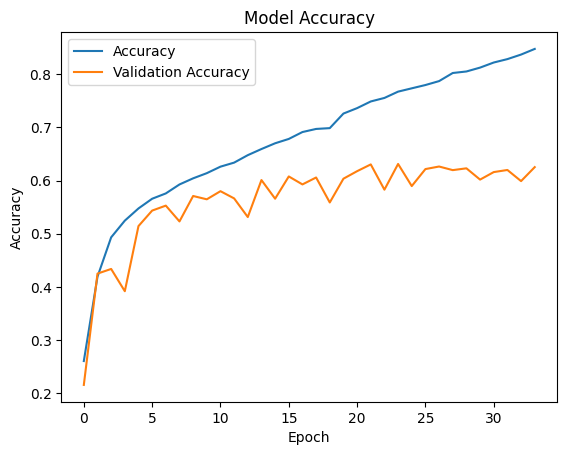

In [14]:
# Show accuracy diagram
plt.title("Model Accuracy")
plt.plot(history1.history["accuracy"], label="accuracy")
plt.plot(history1.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [15]:
# Function for plotting confusion matrix
def plot_cm(cm, classes, normalize):
    title = "Confusion Matrix"
    fmt = ""
    if normalize:
      title = "Confusion Matrix, normalized"
      fmt = ".2f"
      cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(title)
    
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [16]:
#load best models
model1.load_weights(save_path1)

56/56 [==============================] - 2s 25ms/step
[[257  56  40  69  59  10]
 [ 58 255  28  72  67  48]
 [ 16  25 760  36  26  16]
 [ 31  38  68 409  77   3]
 [ 59  97  53 120 259   6]
 [ 13  45  32  18   2 306]]
Accuracy:  0.6355404640633843
56/56 [==============================] - 2s 28ms/step - loss: 1.0383 - accuracy: 0.6355


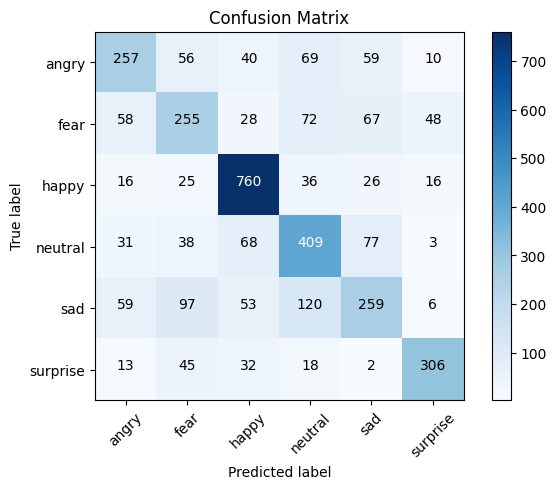

In [17]:
#get true labels

true_labels = test_set.classes

#make predictions
preds1 = model1.predict(test_set)
predicted_labels = np.argmax(preds1, axis=1)

#get confusion matrix
cm1 = confusion_matrix(true_labels, predicted_labels)
print(cm1)
#get accuracy
print("Accuracy: ", np.trace(cm1) / np.sum(cm1))
model1.evaluate(test_set)

#plot
plt.figure()
plot_cm(cm1,classes,False)
plt.show()

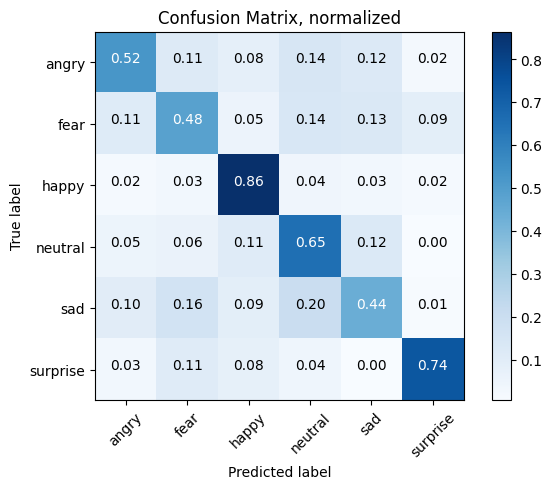

In [18]:
#plot
plt.figure()
plot_cm(cm1,classes,True)
plt.show()

In [19]:
#create hard data from validation set
from sklearn.model_selection import train_test_split

#true labels from validation set
true_labels = val_set.classes

#make predictions on validation set
preds1 = model1.predict(val_set)
predicted_labels = np.argmax(preds1, axis=1)

wrongly_predicted = np.where(predicted_labels != true_labels)[0]
print(len(wrongly_predicted))

images_hard = []
labels_hard = []

for i in range(len(val_set)):
    images = val_set[i][0]
    labels = val_set[i][1]
    for j in range(len(images)):
        if (i * batch + j) in wrongly_predicted:
            images_hard.append(images[j])
            labels_hard.append(labels[j])

print(len(images_hard))

images_hard = np.array(images_hard)
labels_hard = np.array(labels_hard)


images_hard_train, images_hard_test, labels_hard_train, labels_hard_test = train_test_split(images_hard, labels_hard, test_size=0.2)


history1_1 = model1.fit(images_hard_train,\
                        labels_hard_train,\
                        epochs = epochs,\
                        validation_data = (images_hard_test, labels_hard_test),\
                        callbacks=[early_stopping])


56/56 [==============================] - 1s 22ms/step
1303
1303
Epoch 1/100
33/33 [==============================] - 1s 30ms/step - loss: 1.9147 - accuracy: 0.2630 - val_loss: 1.7802 - val_accuracy: 0.2567
Epoch 2/100
33/33 [==============================] - 1s 17ms/step - loss: 1.7436 - accuracy: 0.2476 - val_loss: 1.7283 - val_accuracy: 0.2797
Epoch 3/100
33/33 [==============================] - 1s 18ms/step - loss: 1.6718 - accuracy: 0.2975 - val_loss: 1.8380 - val_accuracy: 0.2682
Epoch 4/100
33/33 [==============================] - 1s 19ms/step - loss: 1.5544 - accuracy: 0.3301 - val_loss: 2.0724 - val_accuracy: 0.2529
Epoch 5/100
33/33 [==============================] - 1s 18ms/step - loss: 1.5421 - accuracy: 0.3676 - val_loss: 1.8314 - val_accuracy: 0.2567
Epoch 6/100
33/33 [==============================] - 1s 22ms/step - loss: 1.6026 - accuracy: 0.3589 - val_loss: 1.8217 - val_accuracy: 0.2452
Epoch 7/100
33/33 [==============================] - 1s 20ms/step - loss: 1.4889 - a

In [20]:
#set training data with data augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,\
                                   shear_range = 0.05,\
                                   brightness_range = [0.9,1.1],\
                                   zoom_range = 0.05,\
                                   rotation_range=5,\
                                   width_shift_range=0.05,\
                                   height_shift_range=0.05,\
                                   horizontal_flip = True)


#get training set
training_set = train_datagen.flow_from_directory(train_dir,\
                                                 target_size = (48, 48),\
                                                 batch_size = batch,\
                                                 color_mode = "grayscale",\
                                                 class_mode = "categorical",\
                                                 shuffle = True,\
                                                 classes=classes)


Found 28273 images belonging to 6 classes.


In [21]:
#save_paths
save_path1_1 = "./drive/MyDrive/model1_hard_aug.h5"
checkpoint1_1 = ModelCheckpoint(save_path1_1, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")

#RLP
reduce_learning_rate = ReduceLROnPlateau(monitor="val_loss", factor=0.9, patience=5, min_lr=0.0001)

#Epochs
epochs = 100

#fit model1
history1_1 = model1.fit(training_set,epochs = epochs,\
                        validation_data = val_set,\
                        callbacks=[checkpoint1_1, reduce_learning_rate])

Epoch 1/100
442/442 [==============================] - ETA: 0s - loss: 1.2035 - accuracy: 0.5447
Epoch 1: val_accuracy improved from -inf to 0.66261, saving model to ./drive/MyDrive/model1_hard_aug.h5
442/442 [==============================] - 37s 84ms/step - loss: 1.2035 - accuracy: 0.5447 - val_loss: 0.8566 - val_accuracy: 0.6626 - lr: 0.0073
Epoch 2/100
442/442 [==============================] - ETA: 0s - loss: 1.0719 - accuracy: 0.5897
Epoch 2: val_accuracy did not improve from 0.66261
442/442 [==============================] - 36s 82ms/step - loss: 1.0719 - accuracy: 0.5897 - val_loss: 0.9406 - val_accuracy: 0.6411 - lr: 0.0073
Epoch 3/100
442/442 [==============================] - ETA: 0s - loss: 1.0322 - accuracy: 0.6090
Epoch 3: val_accuracy improved from 0.66261 to 0.68072, saving model to ./drive/MyDrive/model1_hard_aug.h5
442/442 [==============================] - 36s 82ms/step - loss: 1.0322 - accuracy: 0.6090 - val_loss: 0.9878 - val_accuracy: 0.6807 - lr: 0.0073
Epoch 4/1

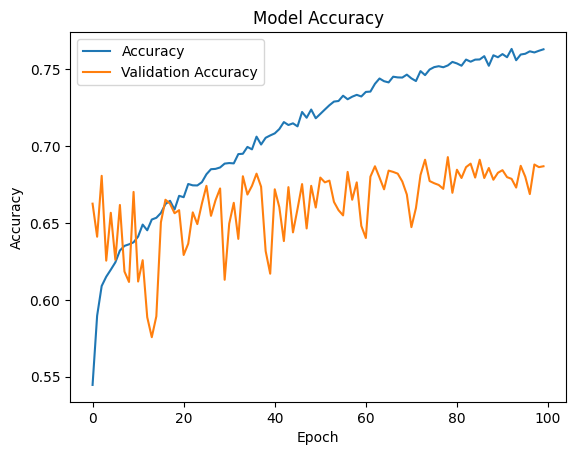

In [22]:
# Show accuracy diagram
plt.title("Model Accuracy")
plt.plot(history1_1.history["accuracy"], label="accuracy")
plt.plot(history1_1.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [24]:
#save last one
model1.save("./drive/MyDrive/model1_100epoch.h5")
#evaluate current
_, model_100e_accuracy = model1.evaluate(test_set)
#load best models
model1.load_weights(save_path1_1)
#evaluate "best"
_, model_checkpoint_accuracy = model1.evaluate(test_set)

if model_100e_accuracy > model_checkpoint_accuracy:
    model1.load_weights("./drive/MyDrive/model1_100epoch.h5")

56/56 [==============================] - 1s 23ms/step - loss: 0.8697 - accuracy: 0.6933


56/56 [==============================] - 2s 32ms/step
[[306  32  24  66  57   6]
 [ 68 239  14  71  89  47]
 [ 15   9 780  38  20  17]
 [ 24  20  29 469  75   9]
 [ 62  47  26 123 329   7]
 [  8  28  20   8   6 346]]
Accuracy:  0.698641765704584
56/56 [==============================] - 1s 24ms/step - loss: 0.8995 - accuracy: 0.6986


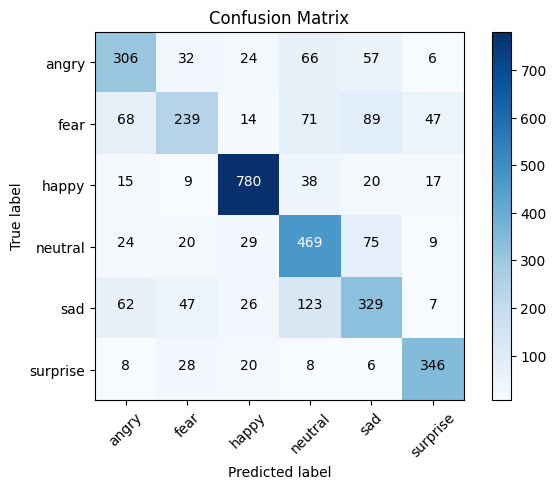

In [25]:
#get true labels
true_labels = test_set.classes

#make predictions
preds1 = model1.predict(test_set)
predicted_labels = np.argmax(preds1, axis=1)

#get confusion matrix
cm2 = confusion_matrix(true_labels, predicted_labels)
print(cm2)

#get accuracy
print("Accuracy: ", np.trace(cm2) / np.sum(cm2))
model1.evaluate(test_set)

#plot
plt.figure()
plot_cm(cm2,classes, False)
plt.show()

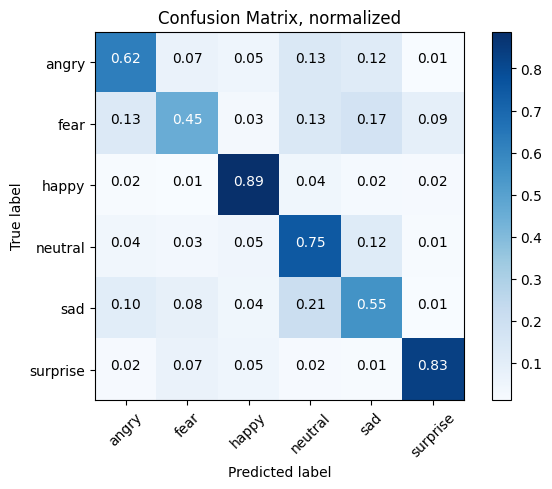

In [26]:
#plot
plt.figure()
plot_cm(cm2,classes, True)
plt.show()

In [27]:
#!pip install tensorflow-model-optimization

In [28]:
#todo optimize with pruning (and quantization) https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras

#second notebook